## MLB Ticket Price Prediction

In [1]:
# Loading libraries #

from bs4 import BeautifulSoup
import requests
import re
from time import sleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import undetected_chromedriver as uc
from selenium.webdriver.chrome.options import Options
import pymongo
import json
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score

In [2]:
# Obtaining IP Address proxies for rotation #

driver = webdriver.Chrome()
def get_free_proxies(driver):
    driver.get('https://sslproxies.org')
    table = driver.find_element(By.TAG_NAME, 'table')
    thead = table.find_element(By.TAG_NAME, 'thead').find_elements(By.TAG_NAME, 'th')
    tbody = table.find_element(By.TAG_NAME, 'tbody').find_elements(By.TAG_NAME, 'tr')
    headers = []
    for th in thead:
        headers.append(th.text.strip())
    proxies = []
    for tr in tbody:
        proxy_data = {}
        tds = tr.find_elements(By.TAG_NAME, 'td')
        for i in range(len(headers)):
            proxy_data[headers[i]] = tds[i].text.strip()
        proxies.append(proxy_data)
    driver.close()
    driver.quit()
    return proxies
free_proxies = get_free_proxies(driver)
print(len(free_proxies))
print(free_proxies)

100
[{'IP Address': '87.255.6.218', 'Port': '8080', 'Code': 'RU', 'Country': 'Russian Federation', 'Anonymity': 'anonymous', 'Google': '', 'Https': 'yes', 'Last Checked': '3 secs ago'}, {'IP Address': '51.79.50.46', 'Port': '9300', 'Code': 'CA', 'Country': 'Canada', 'Anonymity': 'elite proxy', 'Google': 'no', 'Https': 'yes', 'Last Checked': '3 secs ago'}, {'IP Address': '12.218.209.130', 'Port': '53281', 'Code': 'US', 'Country': 'United States', 'Anonymity': 'anonymous', 'Google': '', 'Https': 'yes', 'Last Checked': '3 secs ago'}, {'IP Address': '103.242.119.88', 'Port': '80', 'Code': 'IN', 'Country': 'India', 'Anonymity': 'anonymous', 'Google': '', 'Https': 'yes', 'Last Checked': '3 secs ago'}, {'IP Address': '83.222.6.82', 'Port': '3128', 'Code': 'UZ', 'Country': 'Uzbekistan', 'Anonymity': 'elite proxy', 'Google': 'no', 'Https': 'yes', 'Last Checked': '3 secs ago'}, {'IP Address': '157.230.226.230', 'Port': '1202', 'Code': 'US', 'Country': 'United States', 'Anonymity': 'anonymous', '

### Scraping Tickets for San Francisco Giants

In [3]:
# Getting list of URLs of all games #

driver = webdriver.Chrome()
driver.implicitly_wait(10)
driver.set_script_timeout(120)
driver.set_page_load_timeout(120)
driver.get("https://www.mlb.com/giants/tickets")
games = driver.find_elements(By.CLASS_NAME,"ticket-link.ticket-link-text.p-tfl.ticket-grid--md-hidden.ticket-grid--singlecol-hidden.ticket-link")
link_list = []
for game in games:
    link_list.append(game.get_attribute('href'))
driver.close()
driver.quit()
len(link_list)

81

In [4]:
# Running a test for Game 1 #

i = 0
driver = uc.Chrome()
driver.implicitly_wait(10)
driver.set_script_timeout(120)
driver.set_page_load_timeout(120)
url = link_list[i]
driver.get(url)
time.sleep(10)
team = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.font-primary-bold span.event-name.font-rg.font-elipsis-overflow.ng-binding").text
date = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.small-line.font-primary.font-xxs.font-elipsis-overflow.ng-binding.ng-scope").text
seats = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.first-line")
names = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.second-line")
prices = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-price.ng-scope")
ticket_list = []
for j in range(len(seats)):
    ticket_dict = {}
    ticket_dict['Away_Team'] = re.sub("AT GIANTS","",team)
    ticket_dict['Date'] = re.sub(",","",date[5:11])
    ticket_dict['Seat_Number'] = seats[j].text
    ticket_dict['Seat_Name'] = names[j].text
    ticket_dict['Price'] = prices[j].text
    ticket_list.append(ticket_dict)
driver.close()
driver.quit()
ticket_list

[{'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'SRO',
  'Seat_Name': 'The 415',
  'Price': '$49.00'},
 {'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'VR305',
  'Seat_Name': 'View Reserve Right Field',
  'Price': '$59.00'},
 {'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'VR304',
  'Seat_Name': 'View Reserve Right Field',
  'Price': '$59.00'},
 {'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'VR325',
  'Seat_Name': 'View Reserve Outfield',
  'Price': '$59.00'},
 {'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'VR326',
  'Seat_Name': 'View Reserve Outfield',
  'Price': '$59.00'},
 {'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'VR327',
  'Seat_Name': 'View Reserve Outfield',
  'Price': '$59.00'},
 {'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'VR328',
  'Seat_Name': 'View Reserve Outfield',
  'Price': '$59.00'},
 {'Away_Team': 'ROYALS ',
  'Date': 'APR 7',
  'Seat_Number': 'VR330',
  'Seat_

In [ ]:
# Running the loop for all games #

n = 0
ticket_list = []
for i in range(len(link_list)):
    k = 0
    while k == 0:
        if n == len(free_proxies):
            n = 0
        try:
            PROXY = free_proxies[n]['IP Address'] + ":" + free_proxies[n]['Port']
            chrome_options = uc.ChromeOptions()
            chrome_options.add_argument('--proxy-server=%s' % PROXY)
            driver = uc.Chrome(options=chrome_options)
            driver.implicitly_wait(10)
            driver.set_script_timeout(120)
            driver.set_page_load_timeout(120)
            url = link_list[i]
            driver.get(url)
            time.sleep(10)
            team = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.font-primary-bold span.event-name.font-rg.font-elipsis-overflow.ng-binding").text
            date = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.small-line.font-primary.font-xxs.font-elipsis-overflow.ng-binding.ng-scope").text
            seats = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.first-line")
            names = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.second-line")
            prices = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-price.ng-scope")
            for j in range(len(seats)):
                ticket_dict = {}
                ticket_dict['Away_Team'] = re.sub("AT GIANTS","",team)
                ticket_dict['Date'] = re.sub(",","",date[5:11])
                ticket_dict['Seat_Number'] = seats[j].text
                ticket_dict['Seat_Name'] = names[j].text
                ticket_dict['Price'] = prices[j].text
                ticket_list.append(ticket_dict)
            driver.close()
            driver.quit()
            print("Page {} scraped.".format(i+1))
            time.sleep(10)
            k = 1
        except:
            print("Page {} is throwing an error.".format(i+1))
            n = n + 1
            driver.close()
            driver.quit()
            time.sleep(10)

In [ ]:
# Placing the data into a MongoDB Collection #

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Tickets"]
col = db["Giants"]
col.insert_many(ticket_list)

### Scraping Tickets for New York Mets

In [5]:
# Getting list of URLs of all games #

driver = webdriver.Chrome()
driver.implicitly_wait(10)
driver.set_script_timeout(120)
driver.set_page_load_timeout(120)
driver.get("https://www.mlb.com/mets/tickets/single-game-tickets")
games = driver.find_elements(By.CLASS_NAME,"styles__BuyTicketsButton-sc-1qz8r0a-14.dbzRub")
link_list = []
for game in games:
    link_list.append(game.get_attribute('href'))
driver.close()
driver.quit()
len(link_list)

81

In [6]:
# Running a test for Game 1 #

i = 0
driver = uc.Chrome()
driver.implicitly_wait(10)
driver.set_script_timeout(120)
driver.set_page_load_timeout(120)
url = link_list[i]
driver.get(url)
time.sleep(10)
team = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.font-primary-bold span.event-name.font-rg.font-elipsis-overflow.ng-binding").text
date = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.small-line.font-primary.font-xxs.font-elipsis-overflow.ng-binding.ng-scope").text
seats = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.first-line")
names = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.second-line")
prices = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-price.ng-scope")
ticket_list = []
for j in range(len(seats)):
    ticket_dict = {}
    ticket_dict['Away_Team'] = re.sub("AT METS","",team)
    ticket_dict['Date'] = re.sub(",","",date[5:11])
    ticket_dict['Seat_Number'] = seats[j].text
    ticket_dict['Seat_Name'] = names[j].text
    ticket_dict['Price'] = re.sub("\n.+","",prices[j].text)
    ticket_list.append(ticket_dict)
driver.close()
driver.quit()
ticket_list

[{'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '123',
  'Seat_Name': 'Metropolitan Gold',
  'Price': '$704.50'},
 {'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '126',
  'Seat_Name': 'Field Gold',
  'Price': '$675.50'},
 {'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '122',
  'Seat_Name': 'Metropolitan Silver',
  'Price': '$603.50'},
 {'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '123',
  'Seat_Name': 'Metropolitan Silver',
  'Price': '$603.50'},
 {'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '111',
  'Seat_Name': 'Metropolitan Silver',
  'Price': '$603.50'},
 {'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '114',
  'Seat_Name': 'Metropolitan Bronze',
  'Price': '$539.50'},
 {'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '121',
  'Seat_Name': 'Metropolitan Bronze',
  'Price': '$539.50'},
 {'Away_Team': 'MARLINS ',
  'Date': 'APR 6',
  'Seat_Number': '122',
  'Seat_Name': 'Metropol

In [ ]:
# Running the loop for all games #

n = 0
ticket_list = []
for i in range(len(link_list)):
    k = 0
    while k == 0:
        if n == len(free_proxies):
            n = 0
        try:
            PROXY = free_proxies[n]['IP Address'] + ":" + free_proxies[n]['Port']
            chrome_options = uc.ChromeOptions()
            chrome_options.add_argument('--proxy-server=%s' % PROXY)
            driver = uc.Chrome(options=chrome_options)
            driver.implicitly_wait(10)
            driver.set_script_timeout(120)
            driver.set_page_load_timeout(120)
            url = link_list[i]
            driver.get(url)
            time.sleep(10)
            team = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.font-primary-bold span.event-name.font-rg.font-elipsis-overflow.ng-binding").text
            date = driver.find_element(By.CSS_SELECTOR,"div.title.event-data.font-uppercase div.small-line.font-primary.font-xxs.font-elipsis-overflow.ng-binding.ng-scope").text
            seats = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.first-line")
            names = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-data div.second-line")
            prices = driver.find_elements(By.CSS_SELECTOR,"div.section-row div.section-price.ng-scope")
            for j in range(len(seats)):
                ticket_dict = {}
                ticket_dict['Away_Team'] = re.sub("AT GIANTS","",team)
                ticket_dict['Date'] = re.sub(",","",date[5:11])
                ticket_dict['Seat_Number'] = seats[j].text
                ticket_dict['Seat_Name'] = names[j].text
                ticket_dict['Price'] = re.sub("\n.+","",prices[j].text)
                ticket_list.append(ticket_dict)
            driver.close()
            driver.quit()
            print("Page {} scraped.".format(i+1))
            time.sleep(10)
            k = 1
        except:
            print("Page {} is throwing an error.".format(i+1))
            n = n + 1
            driver.close()
            driver.quit()
            time.sleep(10)

In [ ]:
# Placing the data into a MongoDB Collection #

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Tickets"]
col = db["Mets"]
col.insert_many(ticket_list)

### Data Cleaning and Exploration

First, we will be retrieving the data we scraped which was stored in a MongoDB collection. Then we will clean this data till it is suitable for further analysis.

In [7]:
# Loading scraped data from MongoDB #

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Tickets"]
giants = db["Giants"]
mets = db["Mets"]

In [8]:
# Loading Giants data into a dataframe #

giants_df = pd.DataFrame(list(giants.find()))
giants_df['Home_Team'] = "San Francisco Giants"
giants_df

,_id,Away_Team,Date,Seat_Number,Seat_Name,Price,Home_Team
0,6412b268a81e84379408a98c,ATHLETICS,MAR 27,VR307,View Reserve Right Field,$9.00,San Francisco Giants
1,6412b268a81e84379408a98d,ATHLETICS,MAR 27,VR305,View Reserve Right Field,$9.00,San Francisco Giants
2,6412b268a81e84379408a98e,ATHLETICS,MAR 27,VR304,View Reserve Right Field,$9.00,San Francisco Giants
3,6412b268a81e84379408a98f,ATHLETICS,MAR 27,VR302,View Reserve Right Field,$9.00,San Francisco Giants
4,6412b268a81e84379408a990,ATHLETICS,MAR 27,VR325,View Reserve Outfield,$9.00,San Francisco Giants
...,...,...,...,...,...,...,...
13045,6412b268a81e84379408dc81,DODGERS,OCT 1,PFC112,Premium Field Club,$303.00,San Francisco Giants
13046,6412b268a81e84379408dc82,DODGERS,OCT 1,PFC109,Premium Field Club,$303.00,San Francisco Giants
13047,6412b268a81e84379408dc83,DODGERS,OCT 1,PFC107,Premium Field Club,$303.00,San Francisco Giants
13048,6412b268a81e84379408dc84,DODGERS,OCT 1,PFC124,Premium Field Club,$303.00,San Francisco Giants


In [9]:
# Loading Mets data into a dataframe #

mets_df = pd.DataFrame(list(mets.find()))
mets_df["Away_Team"] = mets_df["Away_Team"].str.replace("AT METS", "")
mets_df

,_id,Away_Team,Date,Seat_Number,Seat_Name,Price
0,6413d2bfa81e84379408dc87,MARLINS,APR 6,124,Metropolitan Field Platinum,$970.50
1,6413d2bfa81e84379408dc88,MARLINS,APR 6,115,Hyundai Club Platinum,$828.50
2,6413d2bfa81e84379408dc89,MARLINS,APR 6,115,Hyundai Club,$674.50
3,6413d2bfa81e84379408dc8a,MARLINS,APR 6,120,Hyundai Club,$674.50
4,6413d2bfa81e84379408dc8b,MARLINS,APR 6,111,Metropolitan Gold,$663.50
...,...,...,...,...,...,...
10393,6413d2bfa81e843794090520,PHILLIES,OCT 1,534,Promenade Outfield,$23.00
10394,6413d2bfa81e843794090521,PHILLIES,OCT 1,535,Promenade Outfield,$23.00
10395,6413d2bfa81e843794090522,PHILLIES,OCT 1,536,Promenade Outfield,$23.00
10396,6413d2bfa81e843794090523,PHILLIES,OCT 1,537,Promenade Outfield,$23.00


In [10]:
# Combining both datasets #

giants_df['Home_Team'] = "San Francisco Giants"
mets_df['Home_Team'] = "New York Mets"
tickets_df = pd.concat([giants_df,mets_df])
tickets_df

,_id,Away_Team,Date,Seat_Number,Seat_Name,Price,Home_Team
0,6412b268a81e84379408a98c,ATHLETICS,MAR 27,VR307,View Reserve Right Field,$9.00,San Francisco Giants
1,6412b268a81e84379408a98d,ATHLETICS,MAR 27,VR305,View Reserve Right Field,$9.00,San Francisco Giants
2,6412b268a81e84379408a98e,ATHLETICS,MAR 27,VR304,View Reserve Right Field,$9.00,San Francisco Giants
3,6412b268a81e84379408a98f,ATHLETICS,MAR 27,VR302,View Reserve Right Field,$9.00,San Francisco Giants
4,6412b268a81e84379408a990,ATHLETICS,MAR 27,VR325,View Reserve Outfield,$9.00,San Francisco Giants
...,...,...,...,...,...,...,...
10393,6413d2bfa81e843794090520,PHILLIES,OCT 1,534,Promenade Outfield,$23.00,New York Mets
10394,6413d2bfa81e843794090521,PHILLIES,OCT 1,535,Promenade Outfield,$23.00,New York Mets
10395,6413d2bfa81e843794090522,PHILLIES,OCT 1,536,Promenade Outfield,$23.00,New York Mets
10396,6413d2bfa81e843794090523,PHILLIES,OCT 1,537,Promenade Outfield,$23.00,New York Mets


In [11]:
# Cleaning the dataset #

#Dropping id column#
tickets_df.drop(['_id'],axis=1,inplace=True)

#Remove the $ from Price and converting to integer#
tickets_df['Price'] = tickets_df['Price'].str.replace('$', '')
tickets_df['Price'] = tickets_df['Price'].apply(lambda x:float(x))

#Removing unwanted whitespace from Away Team#
tickets_df['Away_Team'] = tickets_df['Away_Team'].apply(lambda x:re.sub("\s+$","",x))

tickets_df

/var/folders/tx/bt6mrsk15957dyc9c1xl_rp40000gn/T/ipykernel_9031/545577842.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tickets_df['Price'] = tickets_df['Price'].str.replace('$', '')


,Away_Team,Date,Seat_Number,Seat_Name,Price,Home_Team
0,ATHLETICS,MAR 27,VR307,View Reserve Right Field,9.0,San Francisco Giants
1,ATHLETICS,MAR 27,VR305,View Reserve Right Field,9.0,San Francisco Giants
2,ATHLETICS,MAR 27,VR304,View Reserve Right Field,9.0,San Francisco Giants
3,ATHLETICS,MAR 27,VR302,View Reserve Right Field,9.0,San Francisco Giants
4,ATHLETICS,MAR 27,VR325,View Reserve Outfield,9.0,San Francisco Giants
...,...,...,...,...,...,...
10393,PHILLIES,OCT 1,534,Promenade Outfield,23.0,New York Mets
10394,PHILLIES,OCT 1,535,Promenade Outfield,23.0,New York Mets
10395,PHILLIES,OCT 1,536,Promenade Outfield,23.0,New York Mets
10396,PHILLIES,OCT 1,537,Promenade Outfield,23.0,New York Mets


In [12]:
# Comaparison of prices for Giants vs Mets #

prices_giants = tickets_df[tickets_df['Home_Team'] == "San Francisco Giants"]['Price']
prices_mets = tickets_df[tickets_df['Home_Team'] == "New York Mets"]['Price']
print("Mean ticket price for San Francisco Giants: ${}".format(round(np.mean(prices_giants),2)))
print("Mean ticket price for New York Mets: ${}".format(round(np.mean(prices_mets),2)))
print("Standard deviation of ticket price for San Francisco Giants: ${}".format(round(np.std(prices_giants),2)))
print("Standard deviation of ticket price for New York Mets: ${}".format(round(np.std(prices_mets),2)))
stats.ttest_ind(prices_giants,prices_mets)

Mean ticket price for San Francisco Giants: $65.53
Mean ticket price for New York Mets: $57.92
Standard deviation of ticket price for San Francisco Giants: $61.11
Standard deviation of ticket price for New York Mets: $58.66


Ttest_indResult(statistic=9.640981712260293, pvalue=5.895304660624628e-22)

After comparing the means and standard deviations for both team's ticket prices, we see that they are similar. To further support this, we see that the p-value is not statistically significant when we perform a 2-sample t-test on the ticket prices. Hence, we cannot reject the null hypothesis that the means of both team's ticket prices are equal. Therefore, we can conclude that **tickets for home games of both the San Francisco Giants and the New York Mets are similarly priced**.

Now, we will focus on price prediction for the San Francisco Giants.

One of the main factors influencing the price of a game ticket would be the number of days left until the game. The closer the game is, the more expensive the ticket would be. Hence we will be using today's date and the date of the game to derive the number of days left until the game.

In [13]:
# Converting Date to Number of Days to Game #

tickets_df = tickets_df[tickets_df['Home_Team'] == "San Francisco Giants"]

#Add a new column with Year#
tickets_df['Year'] = 2023

#Combine date and year and create new column with fulldate#
tickets_df["Fulldate"] = tickets_df["Date"] + " " + tickets_df["Year"].astype(str)

#Convert fulldate to datetime#
tickets_df['Fulldate']= pd.to_datetime(tickets_df['Fulldate'])

#Add new column with today's date#
tickets_df['Today'] = pd.Timestamp.today().strftime('%Y-%m-%d')

#Convert Today to datetime#
tickets_df['Today'] = pd.to_datetime(tickets_df['Today'])

#Find Number of Days to Game#
tickets_df["Days_to_Game"] = (tickets_df["Fulldate"] - tickets_df["Today"])
tickets_df["Days_to_Game"] = (tickets_df["Days_to_Game"]).dt.days

#Splitting Seat Number#
tickets_df = tickets_df[tickets_df['Seat_Number'] != "COORS SB"]
tickets_df = tickets_df[tickets_df['Seat_Number'] != "DUG BOX"]
tickets_df['Seat_Type'] = tickets_df['Seat_Number'].apply(lambda x:re.sub("[0-9]+","",x))
tickets_df['Seat_Number'] = tickets_df['Seat_Number'].apply(lambda x:int(re.sub("[A-Z]+","",x)))

tickets_df

/var/folders/tx/bt6mrsk15957dyc9c1xl_rp40000gn/T/ipykernel_9031/1151315877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_df['Year'] = 2023
/var/folders/tx/bt6mrsk15957dyc9c1xl_rp40000gn/T/ipykernel_9031/1151315877.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_df["Fulldate"] = tickets_df["Date"] + " " + tickets_df["Year"].astype(str)
/var/folders/tx/bt6mrsk15957dyc9c1xl_rp40000gn/T/ipykernel_9031/1151315877.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,Away_Team,Date,Seat_Number,Seat_Name,Price,Home_Team,Year,Fulldate,Today,Days_to_Game,Seat_Type
0,ATHLETICS,MAR 27,307,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR
1,ATHLETICS,MAR 27,305,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR
2,ATHLETICS,MAR 27,304,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR
3,ATHLETICS,MAR 27,302,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR
4,ATHLETICS,MAR 27,325,View Reserve Outfield,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR
...,...,...,...,...,...,...,...,...,...,...,...
13045,DODGERS,OCT 1,112,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC
13046,DODGERS,OCT 1,109,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC
13047,DODGERS,OCT 1,107,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC
13048,DODGERS,OCT 1,124,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC


In [14]:
# Reading Away Team Name Mappings #

mapping = pd.read_csv("MLB_Team_Name_Map.csv")
mapping

,Away_Team,Full_Team_Name
0,DIAMONDBACKS,Arizona Diamondbacks
1,BRAVES,Atlanta Braves
2,ORIOLES,Baltimore Orioles
3,RED SOX,Boston Red Sox
4,CUBS,Chicago Cubs
5,WHITE SOX,Chicago White Sox
6,REDS,Cincinnati Reds
7,GUARDIANS,Cleveland Guardians
8,ROCKIES,Colorado Rockies
9,TIGERS,Detroit Tigers


In [15]:
# Mapping Full team Names to Away Teams #

tickets_df = tickets_df.merge(mapping,on='Away_Team',how='left')
tickets_df

,Away_Team,Date,Seat_Number,Seat_Name,Price,Home_Team,Year,Fulldate,Today,Days_to_Game,Seat_Type,Full_Team_Name
0,ATHLETICS,MAR 27,307,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR,Oakland Athletics
1,ATHLETICS,MAR 27,305,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR,Oakland Athletics
2,ATHLETICS,MAR 27,304,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR,Oakland Athletics
3,ATHLETICS,MAR 27,302,View Reserve Right Field,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR,Oakland Athletics
4,ATHLETICS,MAR 27,325,View Reserve Outfield,9.0,San Francisco Giants,2023,2023-03-27,2023-03-31,-4,VR,Oakland Athletics
...,...,...,...,...,...,...,...,...,...,...,...,...
13029,DODGERS,OCT 1,112,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC,Los Angeles Dodgers
13030,DODGERS,OCT 1,109,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC,Los Angeles Dodgers
13031,DODGERS,OCT 1,107,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC,Los Angeles Dodgers
13032,DODGERS,OCT 1,124,Premium Field Club,303.0,San Francisco Giants,2023,2023-10-01,2023-03-31,184,PFC,Los Angeles Dodgers


In [16]:
# Selecting required columns #

tickets_df = tickets_df[['Home_Team','Full_Team_Name','Seat_Type','Seat_Number','Seat_Name','Days_to_Game','Price']]
tickets_df.rename(columns={'Full_Team_Name':'Away_Team'},inplace=True)
tickets_df

/var/folders/tx/bt6mrsk15957dyc9c1xl_rp40000gn/T/ipykernel_9031/82550404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_df.rename(columns={'Full_Team_Name':'Away_Team'},inplace=True)


,Home_Team,Away_Team,Seat_Type,Seat_Number,Seat_Name,Days_to_Game,Price
0,San Francisco Giants,Oakland Athletics,VR,307,View Reserve Right Field,-4,9.0
1,San Francisco Giants,Oakland Athletics,VR,305,View Reserve Right Field,-4,9.0
2,San Francisco Giants,Oakland Athletics,VR,304,View Reserve Right Field,-4,9.0
3,San Francisco Giants,Oakland Athletics,VR,302,View Reserve Right Field,-4,9.0
4,San Francisco Giants,Oakland Athletics,VR,325,View Reserve Outfield,-4,9.0
...,...,...,...,...,...,...,...
13029,San Francisco Giants,Los Angeles Dodgers,PFC,112,Premium Field Club,184,303.0
13030,San Francisco Giants,Los Angeles Dodgers,PFC,109,Premium Field Club,184,303.0
13031,San Francisco Giants,Los Angeles Dodgers,PFC,107,Premium Field Club,184,303.0
13032,San Francisco Giants,Los Angeles Dodgers,PFC,124,Premium Field Club,184,303.0


We will also be merging our data with an external dataset from Kaggle to obtain some additional variables that hep detail the away team.

In [17]:
# Reading external file for additional fields #

extra_fields = pd.read_csv("MLB_Attendance.csv")
extra_fields

,team_full,home_attendance,avg_attendance,capacity,avg_att_percent,rating_avg_2022
0,Arizona Diamondbacks,2118747.364,26157.37486,"48,405",0.540386,1471.422760
1,Atlanta Braves,2392571.273,29537.91695,"41,084",0.718964,1565.639083
2,Baltimore Orioles,1970353.182,24325.34792,"45,971",0.529146,1471.926174
3,Boston Red Sox,2960870.545,36553.95735,"37,755",0.968189,1516.361104
4,Chicago Cubs,3004946.091,37098.09989,"41,649",0.890732,1471.336518
5,Chicago White Sox,1841364.727,22732.89787,"40,615",0.559717,1517.609369
6,Cincinnati Reds,2088080.909,25778.77666,"42,319",0.609154,1468.834326
7,Cleveland Indians,1664532.455,20549.78339,"34,830",0.590002,1513.751536
8,Colorado Rockies,2784254.909,34373.51740,"50,144",0.685496,1457.399192
9,Detroit Tigers,2508999.273,30975.29966,"41,083",0.753969,1454.976296


Text(0, 0.5, 'Average Attendance')

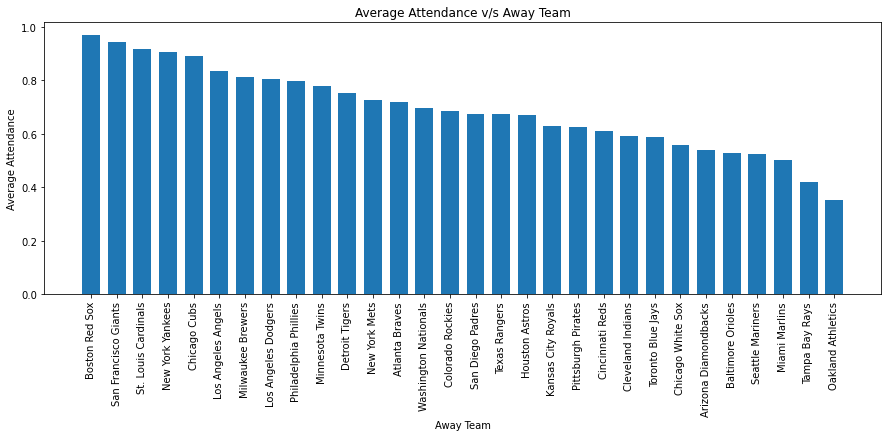

In [18]:
# Visualizing teams with best attendance #

best_att = extra_fields.sort_values(by=['avg_att_percent'],ascending=False)
plt.figure(figsize=(15,5))
plt.bar(best_att['team_full'],best_att['avg_att_percent'],width=0.7)
plt.xticks(range(len(best_att['team_full'])), best_att['team_full'], rotation=90)
plt.title('Average Attendance v/s Away Team')
plt.xlabel('Away Team')
plt.ylabel('Average Attendance')

We see that teams in larger metropolitan cities like Boston, San Francisco and New York have higher average attendance.

Text(0, 0.5, 'Average Rating')

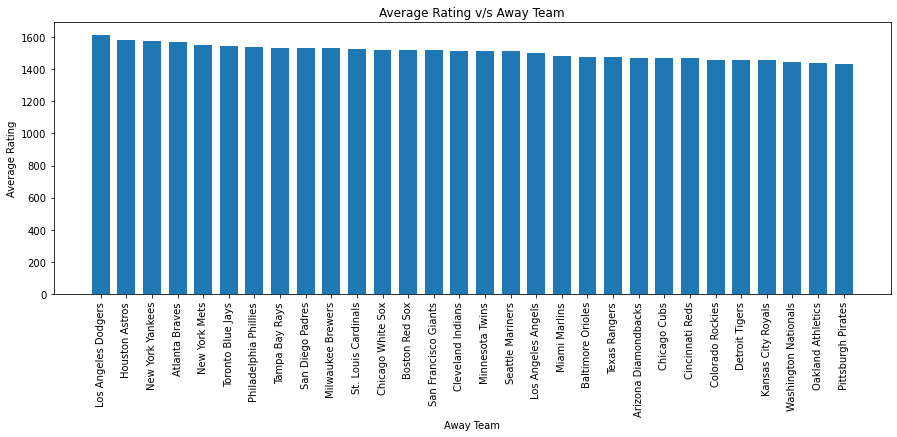

In [19]:
# Visualizing teams with best rating #

best_rat = extra_fields.sort_values(by=['rating_avg_2022'],ascending=False)
plt.figure(figsize=(15,5))
plt.bar(best_rat['team_full'],best_rat['rating_avg_2022'],width=0.7)
plt.xticks(range(len(best_rat['team_full'])), best_rat['team_full'], rotation=90)
plt.title('Average Rating v/s Away Team')
plt.xlabel('Away Team')
plt.ylabel('Average Rating')

The average rating is based on how well the teams played in 2022.

In [20]:
# Merging extra fields to scraped data #

tickets_df = pd.merge(tickets_df, extra_fields, left_on='Away_Team', right_on='team_full')
tickets_df.drop(['team_full'],axis=1,inplace=True)
tickets_df

,Home_Team,Away_Team,Seat_Type,Seat_Number,Seat_Name,Days_to_Game,Price,home_attendance,avg_attendance,capacity,avg_att_percent,rating_avg_2022
0,San Francisco Giants,Oakland Athletics,VR,307,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,"56,782",0.351772,1439.622811
1,San Francisco Giants,Oakland Athletics,VR,305,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,"56,782",0.351772,1439.622811
2,San Francisco Giants,Oakland Athletics,VR,304,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,"56,782",0.351772,1439.622811
3,San Francisco Giants,Oakland Athletics,VR,302,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,"56,782",0.351772,1439.622811
4,San Francisco Giants,Oakland Athletics,VR,325,View Reserve Outfield,-4,9.0,1617921.545,19974.34007,"56,782",0.351772,1439.622811
...,...,...,...,...,...,...,...,...,...,...,...,...
12517,San Francisco Giants,Cincinnati Reds,PFC,112,Premium Field Club,152,152.0,2088080.909,25778.77666,"42,319",0.609154,1468.834326
12518,San Francisco Giants,Cincinnati Reds,PFC,109,Premium Field Club,152,152.0,2088080.909,25778.77666,"42,319",0.609154,1468.834326
12519,San Francisco Giants,Cincinnati Reds,PFC,107,Premium Field Club,152,152.0,2088080.909,25778.77666,"42,319",0.609154,1468.834326
12520,San Francisco Giants,Cincinnati Reds,PFC,124,Premium Field Club,152,152.0,2088080.909,25778.77666,"42,319",0.609154,1468.834326


In [21]:
# Cleaning new columns #

tickets_df.rename(columns={'avg_attendance':'Avg_Att'},inplace=True)
tickets_df.rename(columns={'capacity':'Capacity'},inplace=True)
tickets_df.rename(columns={'avg_att_percent':'Avg_Att_Perc'},inplace=True)
tickets_df.rename(columns={'rating_avg_2022':'Avg_Rating'},inplace=True)
tickets_df['Capacity'] = tickets_df['Capacity'].apply(lambda x:int(re.sub(",","",x)))
tickets_df

,Home_Team,Away_Team,Seat_Type,Seat_Number,Seat_Name,Days_to_Game,Price,home_attendance,Avg_Att,Capacity,Avg_Att_Perc,Avg_Rating
0,San Francisco Giants,Oakland Athletics,VR,307,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,56782,0.351772,1439.622811
1,San Francisco Giants,Oakland Athletics,VR,305,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,56782,0.351772,1439.622811
2,San Francisco Giants,Oakland Athletics,VR,304,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,56782,0.351772,1439.622811
3,San Francisco Giants,Oakland Athletics,VR,302,View Reserve Right Field,-4,9.0,1617921.545,19974.34007,56782,0.351772,1439.622811
4,San Francisco Giants,Oakland Athletics,VR,325,View Reserve Outfield,-4,9.0,1617921.545,19974.34007,56782,0.351772,1439.622811
...,...,...,...,...,...,...,...,...,...,...,...,...
12517,San Francisco Giants,Cincinnati Reds,PFC,112,Premium Field Club,152,152.0,2088080.909,25778.77666,42319,0.609154,1468.834326
12518,San Francisco Giants,Cincinnati Reds,PFC,109,Premium Field Club,152,152.0,2088080.909,25778.77666,42319,0.609154,1468.834326
12519,San Francisco Giants,Cincinnati Reds,PFC,107,Premium Field Club,152,152.0,2088080.909,25778.77666,42319,0.609154,1468.834326
12520,San Francisco Giants,Cincinnati Reds,PFC,124,Premium Field Club,152,152.0,2088080.909,25778.77666,42319,0.609154,1468.834326


In [22]:
# Checking for any null values #

tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12522 entries, 0 to 12521
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Home_Team        12522 non-null  object 
 1   Away_Team        12522 non-null  object 
 2   Seat_Type        12522 non-null  object 
 3   Seat_Number      12522 non-null  int64  
 4   Seat_Name        12522 non-null  object 
 5   Days_to_Game     12522 non-null  int64  
 6   Price            12522 non-null  float64
 7   home_attendance  12522 non-null  float64
 8   Avg_Att          12522 non-null  float64
 9   Capacity         12522 non-null  int64  
 10  Avg_Att_Perc     12522 non-null  float64
 11  Avg_Rating       12522 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.2+ MB


Text(0, 0.5, 'Ticket Price ($)')

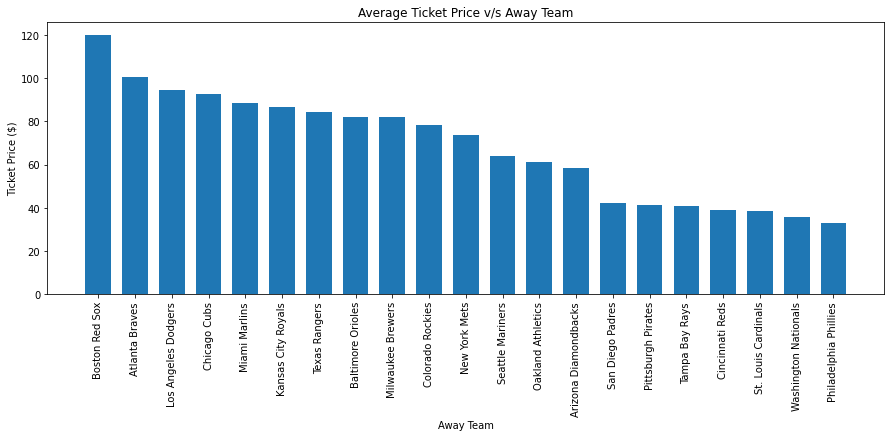

In [23]:
# Visualizing average ticket price by away team #

price_away = tickets_df.groupby('Away_Team').agg({'Price':np.mean})
price_away = price_away.sort_values(by=['Price'],ascending=False)
plt.figure(figsize=(15,5))
plt.bar(price_away.index,price_away['Price'],width=0.7)
plt.xticks(range(len(price_away.index)), price_away.index, rotation=90)
plt.title('Average Ticket Price v/s Away Team')
plt.xlabel('Away Team')
plt.ylabel('Ticket Price ($)')

We can see that average ticket prices are higher for teams that are more popular such as the Boston Red Sox and the LA Dodgers.

Text(0, 0.5, 'Ticket Price ($)')

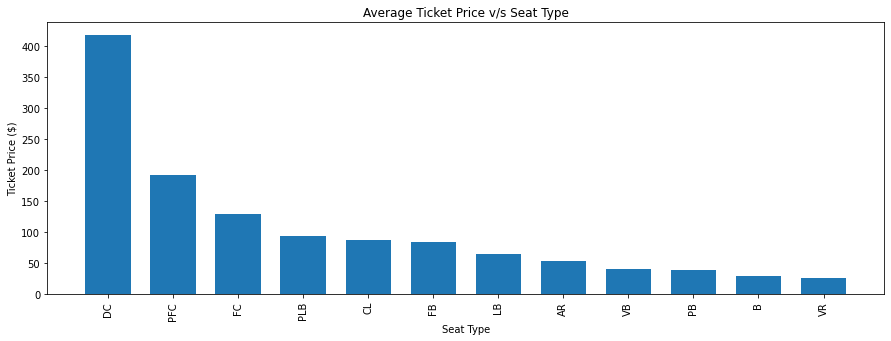

In [24]:
# Visualizing average ticket price by seat type #

price_seat = tickets_df.groupby('Seat_Type').agg({'Price':np.mean})
price_seat = price_seat.sort_values(by=['Price'],ascending=False)
plt.figure(figsize=(15,5))
plt.bar(price_seat.index,price_seat['Price'],width=0.7)
plt.xticks(range(len(price_seat.index)), price_seat.index, rotation=90)
plt.title('Average Ticket Price v/s Seat Type')
plt.xlabel('Seat Type')
plt.ylabel('Ticket Price ($)')

DC or Dugout Club are premiere box tickets and are hence the most expensive. VR or View Reserve are bleacher tickets and hence they are the cheapest.

In [25]:
# Splitting into input and response variables #

X = tickets_df[["Seat_Type","Seat_Number","Away_Team","Days_to_Game","Avg_Att_Perc","Avg_Rating"]]
y = tickets_df["Price"]
print(X.shape)
print(y.shape)

(12522, 6)
(12522,)


To be facilitate model building, we will be converting the away team and seat type columns into dummies since they were categorical in nature.

In [26]:
# Converting Away Team and Seat Type variables into dummies #

X = pd.get_dummies(X, drop_first=True)
X

,Seat_Number,Days_to_Game,Avg_Att_Perc,Avg_Rating,Seat_Type_B,Seat_Type_CL,Seat_Type_DC,Seat_Type_FB,Seat_Type_FC,Seat_Type_LB,...,Away_Team_New York Mets,Away_Team_Oakland Athletics,Away_Team_Philadelphia Phillies,Away_Team_Pittsburgh Pirates,Away_Team_San Diego Padres,Away_Team_Seattle Mariners,Away_Team_St. Louis Cardinals,Away_Team_Tampa Bay Rays,Away_Team_Texas Rangers,Away_Team_Washington Nationals
0,307,-4,0.351772,1439.622811,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,305,-4,0.351772,1439.622811,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,304,-4,0.351772,1439.622811,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,302,-4,0.351772,1439.622811,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,325,-4,0.351772,1439.622811,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12517,112,152,0.609154,1468.834326,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12518,109,152,0.609154,1468.834326,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12519,107,152,0.609154,1468.834326,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12520,124,152,0.609154,1468.834326,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us check the correlation values of all of our input variables with the ticket price.

In [27]:
# Checking correlation of variables with price #

X_y = X.copy()
X_y['Price'] = y
X_y.corr()['Price']

Seat_Number                       -0.427974
Days_to_Game                       0.072176
Avg_Att_Perc                       0.105306
Avg_Rating                         0.081278
Seat_Type_B                       -0.146384
Seat_Type_CL                       0.145098
Seat_Type_DC                       0.578559
Seat_Type_FB                       0.032053
Seat_Type_FC                       0.258799
Seat_Type_LB                      -0.017677
Seat_Type_PB                      -0.065296
Seat_Type_PFC                      0.308617
Seat_Type_PLB                      0.144202
Seat_Type_VB                      -0.144685
Seat_Type_VR                      -0.375339
Away_Team_Atlanta Braves           0.108462
Away_Team_Baltimore Orioles        0.049270
Away_Team_Boston Red Sox           0.167264
Away_Team_Chicago Cubs             0.082822
Away_Team_Cincinnati Reds         -0.092169
Away_Team_Colorado Rockies         0.055953
Away_Team_Kansas City Royals       0.054903
Away_Team_Los Angeles Dodgers   

We observe that Seat_Type_DC has the highest correlation with ticket price. This is because it is a dummy variable indicating if the ticket is a Dugout Club one. Since these tickets are for premiere seating, they would have a very high price. Hence, the high correlation.

Finally, we will perfrom a 80:20 train-test split on our dataset.

In [28]:
# Performing a train-test 80:20 split #

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

### Buiding a Regression Model

In [29]:
# Adding intercept to input variables #

X_train_int = sm.add_constant(X_train)
X_test_int = sm.add_constant(X_test)

In [30]:
# Running a linear regression model and printing the summary #

lin_reg = sm.OLS(y_train,X_train_int).fit()
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1424.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:17:59   Log-Likelihood:                -46840.
No. Observations:               10017   AIC:                         9.375e+04
Df Residuals:                    9983   BIC:                         9.399e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

We observe that all of our variables are statistically significant at a significance level of 0.05, except for Seat_Type_LB.

Our model has a training R-squared value of 82.5%. This shows good in-sample performance. However, for model selection we will be looking for good out-of-sample performance. Hence we will be looking at test Mean-Squared Error of the model.

In [31]:
# Finding train and test MSE #

y_pred = lin_reg.predict(X_train_int)
train_mse_lin_reg = mean_squared_error(y_train,y_pred)
print("Train MSE = {}".format(train_mse_lin_reg))
y_pred = lin_reg.predict(X_test_int)
test_mse_lin_reg = mean_squared_error(y_test,y_pred)
print("Test MSE = {}".format(test_mse_lin_reg))

Train MSE = 674.6263985910019
Test MSE = 603.0010735724227


Now, let us see if we can improve our test performance by using a regularized technique like Lasso regression.

In [32]:
# Declaring lambda values for GridSearchCV #

lambda_vals = []
for n in np.arange(0,20,1):
    lambda_vals.append(1/np.power(10,n))
lambda_vals

[1.0,
 0.1,
 0.01,
 0.001,
 0.0001,
 1e-05,
 1e-06,
 1e-07,
 1e-08,
 1e-09,
 1e-10,
 1e-11,
 1e-12,
 1e-13,
 1e-14,
 1e-15,
 1e-16,
 1e-17,
 1e-18,
 -1.1838881245526248e-19]

In [33]:
# Using GridSearchCV to find value of lambda with minimum MSE for Lasso #

model = Lasso()
cv = RepeatedKFold(n_splits=8, n_repeats=3, random_state=21)
grid = dict()
grid['alpha'] = lambda_vals
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
las_reg = search.fit(X_train,y_train)
min_alpha = las_reg.best_params_['alpha']
print("MSE = {}".format(las_reg.best_score_))
print("Min Lambda value = {}".format(min_alpha))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.583e+04, tolerance: 3.393e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+04, tolerance: 3.384e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.763e+04, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e+06, tolerance: 3.384e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.964e+06, tolerance: 3.385e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.957e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.713e+06, tolerance: 3.164e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.962e+06, tolerance: 3.398e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+06, tolerance: 3.164e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e+06, tolerance: 3.381e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.990e+06, tolerance: 3.384e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.939e+06, tolerance: 3.312e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.013e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e+06, tolerance: 3.384e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+06, tolerance: 3.351e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.848e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.959e+06, tolerance: 3.361e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e+06, tolerance: 3.384e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.900e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e+06, tolerance: 3.426e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.848e+06, tolerance: 3.328e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e+06, tolerance: 3.385e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.990e+06, tolerance: 3.384e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e+06, tolerance: 3.164e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.013e+06, tolerance: 3.491e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+06, toleranc

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+06, tolerance: 3.312e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


MSE = -683.3961613241295
Min Lambda value = 1e-16


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.379e+06, tolerance: 3.858e+03
  model = cd_fast.enet_coordinate_descent(


In [34]:
# Checking the coefficients of our Lasso Regression model #

las_reg = Lasso(alpha = min_alpha).fit(X_train,y_train)
las_reg.coef_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.379e+06, tolerance: 3.858e+03
  model = cd_fast.enet_coordinate_descent(


array([-4.25026892e-01,  9.57750201e-02,  4.60846082e+01,  2.05534448e-02,
       -2.62188608e+01,  6.38041774e+01,  3.48513076e+02,  2.41834720e+01,
        5.85748556e+01, -3.07933850e+00, -1.62515865e+01,  1.20934529e+02,
        2.41057921e+01,  5.95148644e+01,  4.44294716e+01,  2.68385504e+01,
        3.00387086e+01,  4.07862625e+01,  2.41567518e+01, -2.45591741e+01,
        1.14230601e+01,  4.18789877e+01,  2.70027788e+01,  3.85088406e+01,
        1.75388369e+01,  1.64960203e+01,  1.85923967e+01, -2.60080298e+01,
       -1.31106873e+01, -2.35018005e+01,  6.50721426e+00, -2.47838550e+01,
       -1.62363725e+01,  1.87139912e+01, -1.94577191e+01])

We observe that all of our 35 variables have non-zero coefficients. This tells us that all of our variables are important in predicting value of price. This is further supported by the fact that almost all of our variables had statistically significant p-values when a linear regression model was fit.

In [35]:
# Finding test MSE #

y_pred = las_reg.predict(X_train)
train_mse_las_reg = mean_squared_error(y_train,y_pred)
print("Train MSE = {}".format(train_mse_las_reg))
y_pred = las_reg.predict(X_test)
test_mse_las_reg = mean_squared_error(y_test,y_pred)
print("Test MSE = {}".format(test_mse_las_reg))

Train MSE = 674.6263986094617
Test MSE = 603.0009690689463


Our test MSE sees a very slight improvement. Let us see if we can improve it using tree models.

### Building a Decision Tree Model

First, let us build a simple tree that can be visualized.

In [36]:
# Building a simple tree of depth = 3 #

tr_regressor = DecisionTreeRegressor(max_depth=3,random_state=21)
tr_regressor.fit(X_train,y_train)
y_pred = tr_regressor.predict(X_train)
train_mse_tr = mean_squared_error(y_train,y_pred)
print("Train MSE = {}".format(train_mse_tr))
y_pred = tr_regressor.predict(X_test)
test_mse_tr = mean_squared_error(y_test,y_pred)
print("Test MSE = {}".format(test_mse_tr))

Train MSE = 1570.7085450043683
Test MSE = 1632.8532194632078


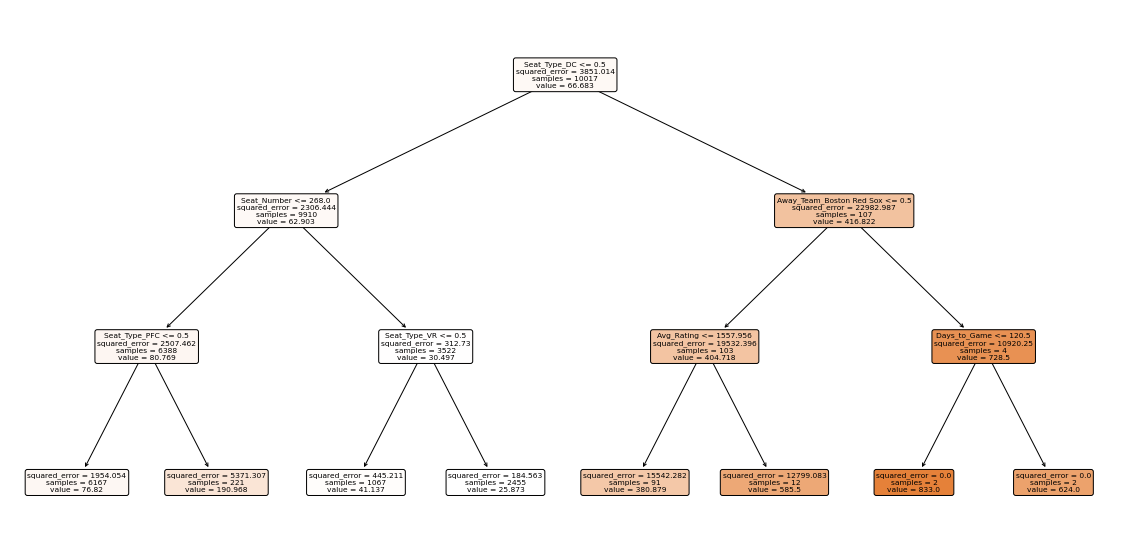

In [37]:
# Visualizing the simple tree #

plt.figure(figsize=(20, 10))
plot_tree(tr_regressor, filled=True, feature_names=X.columns, rounded=True)
plt.show()

Now, let us build a fully grown tree that gives us the best performance.

In [38]:
# Building a fully grown tree #

tr_regressor = DecisionTreeRegressor(random_state=21)
tr_regressor.fit(X_train,y_train)
y_pred = tr_regressor.predict(X_train)
train_mse_tr = mean_squared_error(y_train,y_pred)
print("Train MSE = {}".format(train_mse_tr))
y_pred = tr_regressor.predict(X_test)
test_mse_tr = mean_squared_error(y_test,y_pred)
print("Test MSE = {}".format(test_mse_tr))

Train MSE = 6.192922032544674
Test MSE = 195.02575959192725


As we can see, both our train and test MSE values have drastically improved in comparison to the regression models. However, the very low train MSE indicates overfitting. Let us see if we can overcome this problem by using an ensemble model.

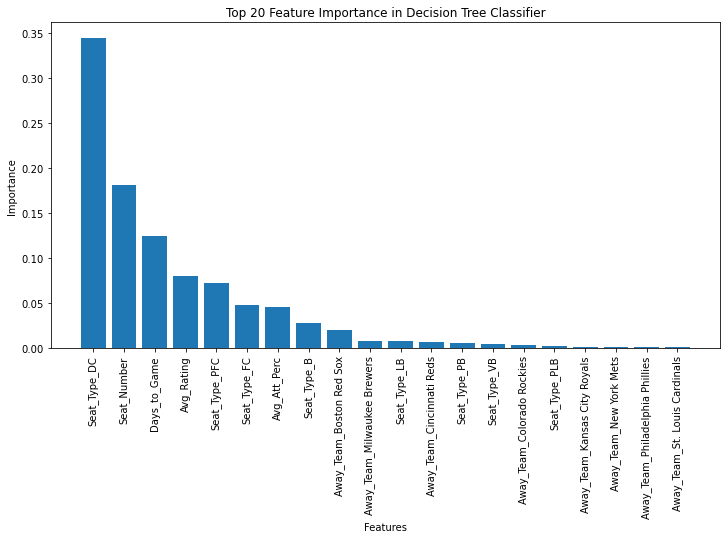

In [39]:
# Checking for the most important features #

importances = tr_regressor.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
k = 20
plt.figure(figsize=(12, 6))
plt.bar(range(k), importances[sorted_indices][:k], align='center')
plt.xticks(range(k), X.columns[sorted_indices][:k], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top {} Feature Importance in Decision Tree Classifier'.format(k))
plt.show()

### Building a Random Forest Model

In [40]:
# Building a Random Forest model #

rf_regressor = RandomForestRegressor(n_estimators=100,random_state=21)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_train)
train_mse_rf = mean_squared_error(y_train,y_pred)
print("Train MSE = {}".format(train_mse_rf))
y_pred = rf_regressor.predict(X_test)
test_mse_rf = mean_squared_error(y_test,y_pred)
print("Test MSE = {}".format(test_mse_rf))

Train MSE = 27.984003297545634
Test MSE = 178.50764772763097


With the random forest ensemble model, our train MSE has seen an increase while our test MSE has seen a decrease. Hence our assumption that the decision tree was overfitting was correct. Our random forest provides better out-of-sample performance as it avoids overfitting by training on a subset of variables. Additionally, the output is an average of the output of all the individual trees.

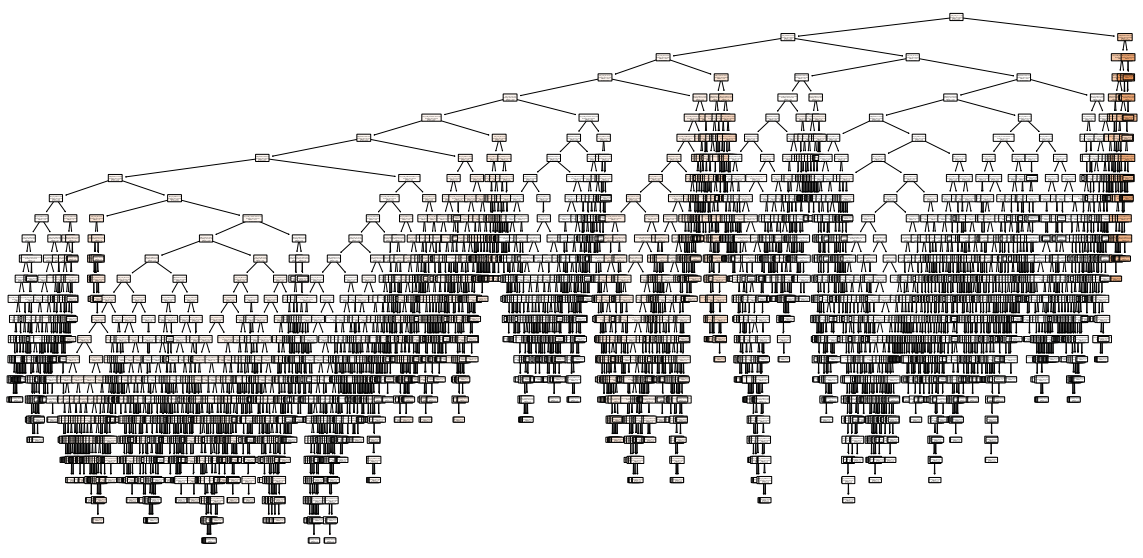

In [41]:
# Visualizing the first tree of the Random Forest #

single_tree = rf_regressor.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(single_tree, filled=True, feature_names=X.columns, rounded=True)
plt.show()

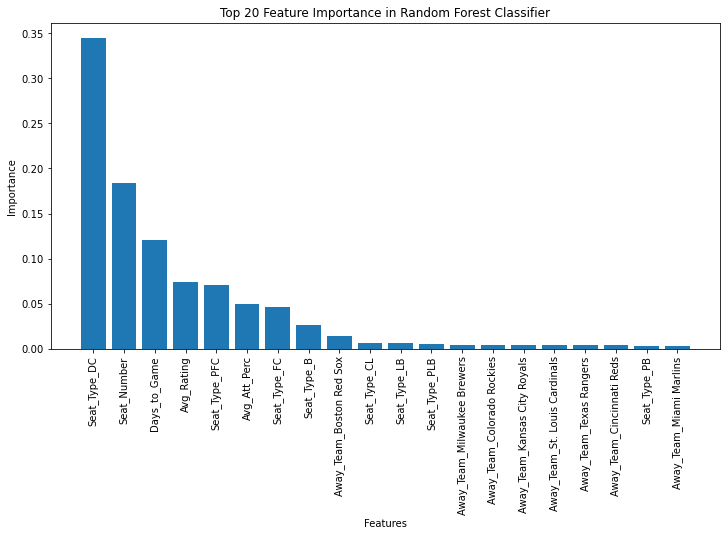

In [42]:
# Checking for the most important features #

importances = rf_regressor.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
k = 20
plt.figure(figsize=(12, 6))
plt.bar(range(k), importances[sorted_indices][:k], align='center')
plt.xticks(range(k), X.columns[sorted_indices][:k], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top {} Feature Importance in Random Forest Classifier'.format(k))
plt.show()

### Conclusion

In [43]:
# Comparing the different models we built #

model_comp = {'Model':['Linear Regression','Lasso Regression','Decision Tree','Random Forest'],
             'Train MSE':[train_mse_lin_reg,train_mse_las_reg,train_mse_tr,train_mse_rf],
             'Test MSE':[test_mse_lin_reg,test_mse_las_reg,test_mse_tr,test_mse_rf]}
model_comp = pd.DataFrame(model_comp)
model_comp

,Model,Train MSE,Test MSE
0,Linear Regression,674.626399,603.001074
1,Lasso Regression,674.626399,603.000969
2,Decision Tree,6.192922,195.025760
3,Random Forest,27.984003,178.507648


After comparing all of our different models, we can conclude that tree models performed much better than our regression models. This can be attributed to the non-linear relationships between ticket price and our variables. Finally, **random forest gives us the best out-of-sample performance** for prediction of ticket price and can be used for future MLB seasons.